<a href="https://colab.research.google.com/github/danfolador/REDES/blob/main/REDES_Exercicio02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EXERCÍCIO 02**

Aluno: Daniel Folador Rossi

Matrícula: 20201mpca0306

---

Implemente uma Rede Neural rasa para classificação de uma base multiclasse.

Esta rede deve:

- Aceitar rótulos que podem ser números ou textos;
- Predizer os rótulos originais da base de dados;
- Passar por parâmetro no construtor:
- Função de custo e cálculo do gradiente;
- Taxa de aprendizado;
- Número máximo de iterações;
- Threshold;
- Funcionar para bases binárias.

Teste pelo menos duas funções de custo diferentes em uma base multiclasse e uma base binária.

Plote gráficos com os hiperplanos separadores encontrados pelos algoritmos de treinamento. Se a base escolhida tiver mais do que 2 características, escolha as que você julgar que fornecem a melhor visualização.

In [11]:
#======================================================
# INICIALIZAÇÃO
#======================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [12]:
#======================================================
# FUNCOES AUXILIARES
#======================================================
def GeraDataSet(tamanho=20, centros=2, random_state=None):
    X, y = make_blobs(n_samples=tamanho, centers=centros, center_box=(0,1.0), cluster_std=0.05, random_state=random_state)
    return X, y

def PlotaDataSet(X, y, transp):
    #plota pra cada classe
    for k in set(y):
        logic = y==k
        plt.plot(X[:,0][logic], X[:,1][logic], 'o', alpha=transp)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.5])

def PlotaVetor(vetor, cor='k', transp=1.0):
    origem= [0,0]
    plt.arrow(*origem, *vetor, color=cor, alpha=transp)

def PlotaHiperplano(vetor, bias=0, xmin=-0.1, xmax=1.2):
    xs = np.linspace(xmin,xmax,num=2)
    ys = (-vetor[0]/vetor[1])* xs - bias / vetor[1]
    plt.plot(xs,ys)

def Perpendicular(vetor):
    perpend = np.array(vetor[::-1])
    perpend[0] *= -1
    return perpend

def CriaCategoricos(y):
    replacements = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f'}
    replacer = replacements.get
    y = [replacer(n, n) for n in y]
    return y

def TrataRotulos(y):
    # Substitui por rótulos numéricos
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)
    
    # Para o caso binário, substitui por -1/+1
    if len(set(y))<=2: y = y*2-1
    return y

In [13]:
#======================================================
# FUNÇÕES DE CUSTO
#======================================================
from sklearn.base import BaseEstimator, ClassifierMixin

# PERCEPTRON
#--------------------------------------------------
class CustoPerceptron():
    @staticmethod
    def Erro(y, ypred):
        return y - ypred
    @staticmethod
    def Custo(y, ypred):
        return np.sum(CustoPerceptron.Erro(y, ypred)**2)
    @staticmethod
    def Gradiente(y, ypred, X):
        return np.matmul(X.T, CustoPerceptron.Erro(y, ypred))

# HINGELOSS
#--------------------------------------------------
class HingeLoss():
    @staticmethod
    def Erro(y, ypred):
        return np.multiply(y, ypred)
    @staticmethod
    def Custo(y, ypred):
        return np.sum(1 - HingeLoss.Erro(y, ypred))
    @staticmethod
    def Gradiente(y, ypred, X):
        marginais = HingeLoss.Erro(y, ypred) < 1
        return np.matmul(y[marginais],X[marginais])

# ADALINE
#--------------------------------------------------
class Adaline():
    def __init__(self):
        self.preactivated = True
    @staticmethod
    def Erro(y, ypred):
        return y - ypred
    @staticmethod
    def Custo(y, ypred):
        return np.sum((1 - Adaline.Erro(y, ypred))**2)
    @staticmethod
    def Gradiente(y, ypred, X):
        return np.matmul(X.T, Adaline.Erro(y, ypred))



In [14]:
#======================================================
# PERCEPTRON
#======================================================
class Perceptron(BaseEstimator, ClassifierMixin):
    
    # INIT
    #--------------------------------------------------
    def __init__(self, fcusto=CustoPerceptron(), alpha=0.2, maxiter=200, threshold=0):
        self.w = None
        self.activation = lambda a: (a>=0)*2 -1
        self.alpha = alpha
        self.maxiter = maxiter
        self.fcusto = fcusto
        self.threshold = threshold
    
    # BIAS
    #--------------------------------------------------
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb

    # FIT
    #--------------------------------------------------        
    def fit(self,X,y):
        
        self.labels = list(set(y))   
        X = Perceptron.includebias(X)
        y = label_binarize(y, classes=self.labels)*2-1       
        if len(self.labels)==2: y = y[:,0:1]
        
        # Treinamento
        self.w = np.random.uniform(-1,1,size=(X.shape[1], y.shape[1]))
        for _  in range(self.maxiter):
            #a = self.preactivate(X)
            a = np.matmul(X, self.w)
            if (hasattr(self.fcusto, 'preactivated') and self.fcusto.preactivated):
                ypred = a
            else:
                ypred = self.activation(a)
            
            custo = self.fcusto.Custo(y,ypred)
            if custo==0:
                break
            self.w = self.w + (self.alpha)*(self.fcusto.Gradiente(y,ypred,X))
    
    # PREDICT
    #--------------------------------------------------     
    def predict(self,X):
        Xb = Perceptron.includebias(X)
        a = np.matmul(Xb, self.w)
            
        #Caso binário
        if self.w.shape[1]<=1:
            logic = self.activation(a) > self.threshold
            idx = np.array(logic, dtype=int)[:,0]
        #Caso multiclasse
        else:
            idx = np.argmax(a, axis=1)
        
        ypred = np.array([self.labels[i] for i in idx])            
        return ypred

In [15]:
#======================================================
# FUNCAO AJUSTE PERCEPTRON
#======================================================
def Ajuste(Xtrain, Xtest, ytrain, ytest,
           fcusto, alpha=0.2, maxiter=200, threshold=0):
    
    perceptron = Perceptron(fcusto=fcusto, alpha=alpha, maxiter=maxiter, threshold=threshold)
    perceptron.fit(Xtrain, ytrain)
    ypred = perceptron.predict(Xtest)          #Prediçao com resubstituição
    acuracia = sum(ytest==ypred)/len(ytest)
   
    # PLOT DE RESULTADOS
    #------------------------------------------------------  
    xannoate = 0.0
    yannoate = 1.4
    plt.annotate('acuracia= ' + str(acuracia), (xannoate,yannoate), color='red')
    PlotaDataSet(Xtest, ytest, transp=0.3)

    # Caso Binário
    if len(set(ytest))<=2:
        pesos = perceptron.w[1:]
        bias = perceptron.w[0]
        PlotaHiperplano(pesos,bias)
       
    # Caso Multiclasse
    else:
        for i in range(len(set(ytest))):
            pesos = perceptron.w[1:,i]
            bias = perceptron.w[0,i]
            PlotaHiperplano(pesos, bias)

    plt.show()

    pesos = perceptron.w[1:]
    bias = perceptron.w[0]

    
    return pesos, bias, acuracia

In [16]:
#======================================================
# BANCO DE DADOS
#======================================================   
# Gera dados
n_classes = 2
X1, y1 = GeraDataSet(200, centros=n_classes, random_state=0)
y1 = CriaCategoricos(y1)

# Gera dados
n_classes = 4
X2, y2 = GeraDataSet(200, centros=n_classes, random_state=42)
y2 = CriaCategoricos(y2)


df1 = pd.DataFrame(X1, columns=['X1','X2'])
df2 = pd.DataFrame(y1, columns=['y'])
df = pd.concat([df1, df2],axis=1)
print('============================')
print('DADOS BRUTOS BINÁRIOS')
print('============================')
print(df.head(10))
print()

df1 = pd.DataFrame(X2, columns=['X1','X2'])
df2 = pd.DataFrame(y2, columns=['y'])
df = pd.concat([df1, df2],axis=1)
print('============================')
print('DADOS BRUTOS MULTICLASSE')
print('============================')
print(df.head(10))
print()


DADOS BRUTOS BINÁRIOS
         X1        X2  y
0  0.641097  0.562698  b
1  0.582791  0.563386  b
2  0.656189  0.522214  b
3  0.570892  0.525020  b
4  0.625452  0.788657  a
5  0.515190  0.697212  a
6  0.556016  0.787903  a
7  0.504424  0.616150  a
8  0.596119  0.529994  b
9  0.467304  0.738328  a

DADOS BRUTOS MULTICLASSE
         X1        X2  y
0  0.825283  0.622350  b
1  0.243553  0.991809  a
2  0.057471  0.821313  d
3 -0.014321  0.795803  d
4  0.126550  0.198475  c
5  0.193383  0.186513  c
6  0.722376  0.613736  b
7  0.034532  0.877779  d
8  0.718761  0.734667  b
9  0.196662  0.187476  c



In [17]:
#======================================================
# TRATAMENTO DOS DADOS
#======================================================   
y1=TrataRotulos(y1)
y2=TrataRotulos(y2)

df1 = pd.DataFrame(X1, columns=['X1','X2'])
df2 = pd.DataFrame(y1, columns=['y'])
df = pd.concat([df1, df2],axis=1)
print('============================')
print('DADOS BINÁRIOS TRATADOS')
print('============================')
print(df.head(10))
print()

df1 = pd.DataFrame(X2, columns=['X1','X2'])
df2 = pd.DataFrame(y2, columns=['y'])
df = pd.concat([df1, df2],axis=1)
print('============================')
print('DADOS MULTICLASSE TRATADOS')
print('============================')
print(df.head(10))
print()


DADOS BINÁRIOS TRATADOS
         X1        X2  y
0  0.641097  0.562698  1
1  0.582791  0.563386  1
2  0.656189  0.522214  1
3  0.570892  0.525020  1
4  0.625452  0.788657 -1
5  0.515190  0.697212 -1
6  0.556016  0.787903 -1
7  0.504424  0.616150 -1
8  0.596119  0.529994  1
9  0.467304  0.738328 -1

DADOS MULTICLASSE TRATADOS
         X1        X2  y
0  0.825283  0.622350  1
1  0.243553  0.991809  0
2  0.057471  0.821313  3
3 -0.014321  0.795803  3
4  0.126550  0.198475  2
5  0.193383  0.186513  2
6  0.722376  0.613736  1
7  0.034532  0.877779  3
8  0.718761  0.734667  1
9  0.196662  0.187476  2



BASE BINÁRIA



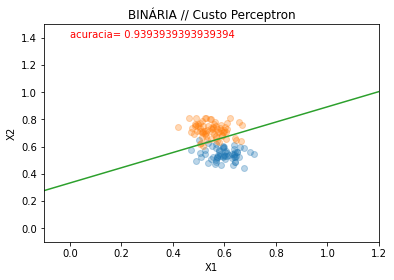

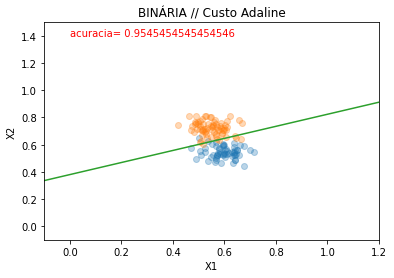

CUSTO PERCEPTRON
----------------------------
pesos= [[-1.75945148]
 [ 3.13946962]]
bias= [-1.0452078]
acuracia= 0.9393939393939394

CUSTO ADALINE
----------------------------
pesos= [[-2.62680507]
 [ 5.91867506]]
bias= [-2.24933834]
acuracia= 0.9545454545454546

BASE MULTICLASSE



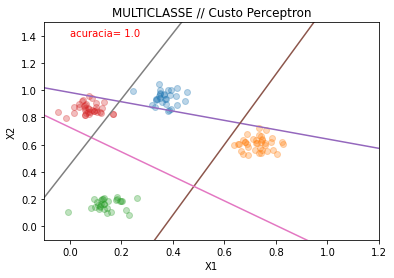

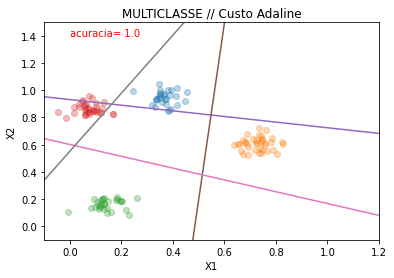

CUSTO PERCEPTRON
----------------------------
pesos= [[ 0.8697828   0.39577686 -0.62489276 -1.00953857]
 [ 2.53743744 -0.15278649 -0.69337109  0.41766555]]
bias= [-2.49753869 -0.14560615  0.50403614 -0.18913131]
acuracia= 1.0

CUSTO ADALINE
----------------------------
pesos= [[ 0.34144218  2.83122227 -1.05243738 -2.12206819]
 [ 1.64575176 -0.21784145 -2.42228489  0.99414686]]
bias= [-1.53362497 -1.37247719  1.45619391 -0.54932765]
acuracia= 1.0



In [29]:
#======================================================
# RODADAS
#======================================================
bases = [(X1,y1),(X2,y2)]
bases_nome = ['BINÁRIA', 'MULTICLASSE']

alpha=0.01
maxiter=200
threshold=0

for (X,y),nome in zip(bases,bases_nome):

    print('============================')
    print('BASE ' + nome)
    print('============================')    
    print()

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.66)
    
    # Custo Perceptron
    #-------------------------
    plt.title(nome + " // Custo Perceptron")
    pesos1, bias1, acuracia1 = Ajuste(Xtrain, Xtest, ytrain, ytest,
                                      fcusto=CustoPerceptron(), alpha=alpha, maxiter=maxiter,threshold=threshold)
    
    
    # Adaline
    #-------------------------
    plt.title(nome + " // Custo Adaline")
    pesos2, bias2, acuracia2 = Ajuste(Xtrain, Xtest, ytrain, ytest,
                                      fcusto=Adaline(), alpha=alpha, maxiter=maxiter,threshold=threshold)
    
    print('CUSTO PERCEPTRON')
    print('----------------------------')
    print('pesos=', pesos1)
    print('bias=', bias1)
    print('acuracia=', acuracia1)
    print()
    
    print('CUSTO ADALINE')
    print('----------------------------')
    print('pesos=', pesos2)
    print('bias=', bias2)
    print('acuracia=', acuracia2)
    print()